In [1]:
import torchvision
import torch,torch.nn
import numpy,cv2
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
na = numpy.newaxis



import copy

class LRPConv0(torch.nn.Module):

    def __init__(self,conv):
        super(LRPConv0, self).__init__()
        self.conv = conv
        self.zconv = copy.deepcopy(conv)
        self.zconv.weight = torch.nn.Parameter(conv.weight)
        self.zconv.bias = torch.nn.Parameter(0*conv.bias)
        self.pconv = copy.deepcopy(conv)
        self.pconv.weight = torch.nn.Parameter(conv.weight.clamp(min=0))
        self.pconv.bias = torch.nn.Parameter(0*conv.bias)
        self.nconv = copy.deepcopy(conv)
        self.nconv.weight = torch.nn.Parameter(conv.weight.clamp(max=0))
        self.nconv.bias = torch.nn.Parameter(0*conv.bias)

    def forward(self,X):
        X,L,H = X
        num = self.zconv(X)-self.pconv(L)-self.nconv(H)
        return num*(self.conv(X)/num).data
        
class LRPPool(torch.nn.Module):

    def __init__(self,pool):
        super(LRPPool, self).__init__()
        self.pool = pool
        self.apool = torch.nn.AvgPool2d(2)
        
    def forward(self,X):
        return self.apool(X**2)*(self.pool(X)/self.apool(X**2+1e-9)).data
    
class LRPConv(torch.nn.Module):
    
    def __init__(self,conv,gamma):
        super(LRPConv, self).__init__()
        self.conv = conv
        self.pconv = copy.deepcopy(conv)
        self.pconv.weight = torch.nn.Parameter(conv.weight+gamma*conv.weight.clamp(min=0))
        self.pconv.bias = torch.nn.Parameter(conv.bias+gamma*conv.bias.clamp(min=0))

    def forward(self,X):
        return self.pconv(X)*(self.conv(X)/self.pconv(X)).data

    
def lrpcnn(cnn):
    cnn = copy.deepcopy(cnn)
    cnn.features[0] = LRPConv0(cnn.features[0])
    for i,gamma in zip([2,5,7,10,12,14,17,19,21,24,26,28],torch.logspace(0,-2,12)):
        cnn.features[i] = LRPConv(cnn.features[i],gamma)
    for i in [4,9,16,23,30]: cnn.features[i] = LRPPool(cnn.features[i])
    for i,gamma in zip([0,3,6],[0.0,0.0,0.0]):
        cnn.classifier[i] = LRPConv(cnn.classifier[i],gamma)
        
    return cnn

In [2]:
mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1,-1,1,1)
std  = torch.Tensor([0.229, 0.224, 0.225]).reshape(1,-1,1,1)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

/home/gregoire/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


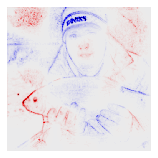

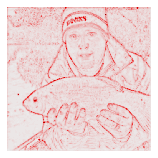

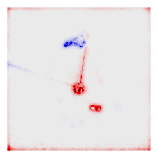

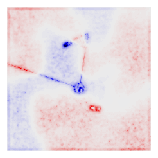

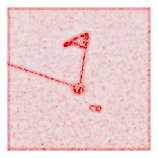

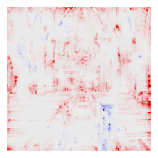

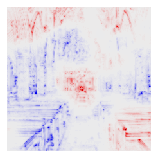

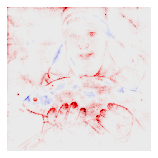

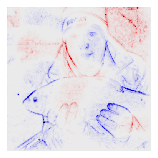

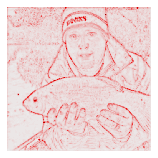

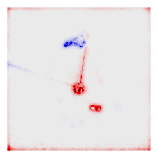

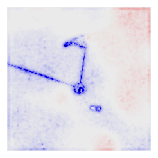

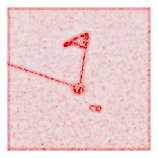

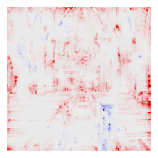

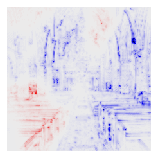

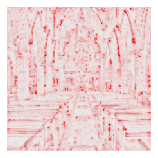

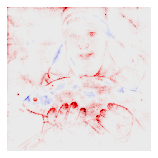

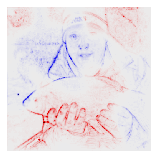

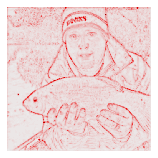

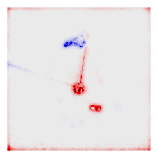

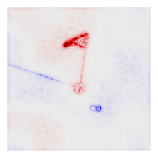

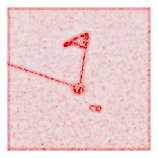

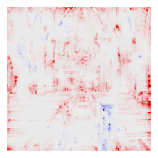

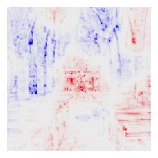

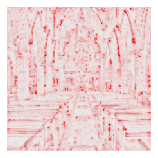

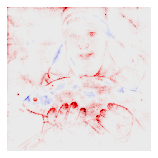

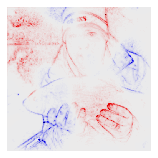

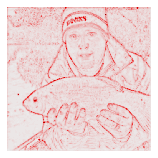

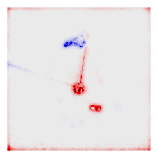

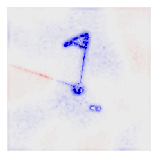

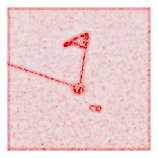

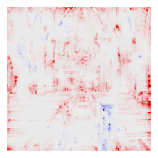

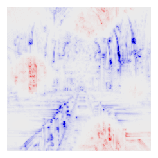

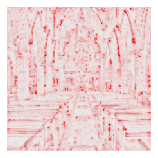

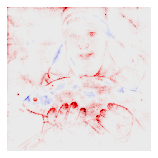

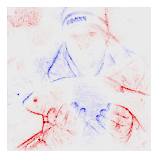

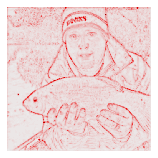

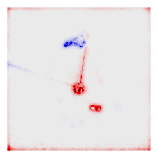

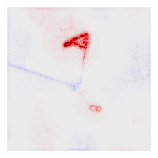

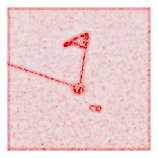

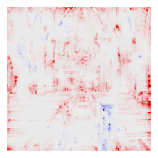

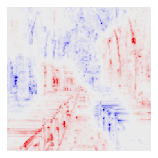

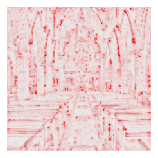

In [3]:

for t in range(1,6):

    torch.manual_seed(t)

    import scipy,scipy.spatial
    from matplotlib.colors import ListedColormap
    my_cmap = plt.cm.seismic(numpy.arange(plt.cm.seismic.N))
    my_cmap[:,0:3] *= 0.925
    my_cmap = ListedColormap(my_cmap)

    for image in 'ABC':

        if image == 'A': img,cl = numpy.array(cv2.imread('ILSVRC2012_val_00017700.JPEG'))[...,::-1]/255.0,0
        if image == 'B': img,cl = numpy.array(cv2.imread('ILSVRC2012_val_00008161.JPEG'))[...,::-1]/255.0,574
        if image == 'C': img,cl = numpy.array(cv2.imread('ILSVRC2012_val_00026451.JPEG'))[...,::-1]/255.0,497

        modelbefore = torchvision.models.vgg16(pretrained=True); modelbefore.eval()
        modelafter = torchvision.models.vgg16(pretrained=True); modelafter.eval()
        modelrand = torchvision.models.vgg16(pretrained=False); modelrand.eval()

        for i in range(12,len(modelafter.features)):
            modelafter.features[i] = modelrand.features[i]
        for i in range(0,len(modelafter.classifier)):
            modelafter.classifier[i] = modelrand.classifier[i]

        if image == 'A' and t==1: print(modelbefore)

        X = (torch.FloatTensor(img[numpy.newaxis].transpose([0,3,1,2])*1) - mean) / std
        L = (X*0+X.min())
        H = (X*0+X.max())
        X.requires_grad_(True);
        L.requires_grad_(True);
        H.requires_grad_(True);
        outbefore = lrpcnn(modelbefore).forward((X,L,H))[:,cl].sum()
        outbefore.backward()

        Rbefore = X * X.grad + L * L.grad + H * H.grad

        plt.figure(figsize=(2,2))
        plt.subplots_adjust(left=0,right=1,bottom=0,top=1)
        plt.axis('off')
        plt.imshow(Rbefore[0].sum(dim=0).data.numpy(),cmap=my_cmap,vmin=-50*Rbefore.std(),vmax=50*Rbefore.std())
        plt.savefig('out/%s-heatmap-before%s.png'%(image,'' if t==1 else '-%d'%t),dpi=224)
        plt.show()

        X = (torch.FloatTensor(img[numpy.newaxis].transpose([0,3,1,2])*1) - mean) / std
        L = (X*0+X.min())
        H = (X*0+X.max())
        X.requires_grad_(True);
        L.requires_grad_(True);
        H.requires_grad_(True);
        outafter = lrpcnn(modelafter).forward((X,L,H))[:,cl].sum()
        outafter.backward()

        Rafter = X * X.grad + L * L.grad + H * H.grad

        plt.figure(figsize=(2,2))
        plt.subplots_adjust(left=0,right=1,bottom=0,top=1)
        plt.axis('off')
        plt.imshow(Rafter[0].sum(dim=0).data.numpy(),cmap=my_cmap,vmin=-50*Rafter.std(),vmax=50*Rafter.std())
        plt.savefig('out/%s-heatmap-after%s.png'%(image,'' if t==1 else '-%d'%t),dpi=224)
        plt.show()


        X = (torch.FloatTensor(img[numpy.newaxis].transpose([0,3,1,2])*1) - mean) / std
        L = (X*0+X.min())
        H = (X*0+X.max())
        X.requires_grad_(True);
        L.requires_grad_(True);
        H.requires_grad_(True);
        outfull = torch.nn.Sequential(lrpcnn(modelbefore).features[:12]).forward((X,L,H))[:,:].sum()
        outfull.backward()

        Rfull = X * X.grad + L * L.grad + H * H.grad

        plt.figure(figsize=(2,2))
        plt.subplots_adjust(left=0,right=1,bottom=0,top=1)
        plt.axis('off')
        plt.imshow(Rfull[0].sum(dim=0).data.numpy(),cmap=my_cmap,vmin=-50*Rfull.std(),vmax=50*Rfull.std())
        plt.savefig('out/%s-heatmap-full%s.png'%(image,'' if t==1 else '-%d'%t),dpi=224)
        plt.show()

